<a href="https://colab.research.google.com/github/smpark0520/ESAA/blob/main/%EB%94%A5%EB%9F%AC%EB%8B%9D_%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98_%EA%B5%90%EA%B3%BC%EC%84%9C_ch7_5_p_393~417.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 7.5 LSTM

* RNN의 단점: 기울기 소실 문제
* 원인: 반복적 가중치 곱으로 기울기 감소
* 해결책: LSTM, GRU 같은 확장 구조 사용


## 7.5.1 LSTM 구조

### LSTM 순전파

LSTM은 **기울기 소실 문제**를 해결하기 위해 다음과 같은 **3가지 게이트**를 사용:

### 1. 망각 게이트 (Forget Gate)

* 역할: **과거 정보의 보존 여부 결정**
* 수식:

  $$
  f_t = \sigma(W_f [h_{t-1}, x_t]) \\
  C_t = f_t \cdot C_{t-1}
  $$
* \$\sigma\$ 값 → 0: 버림 / 1: 유지

---

### 2. 입력 게이트 (Input Gate)

* 역할: **현재 입력을 셀 상태에 반영**
* 수식:

  $$
  i_t = \sigma(W_i [h_{t-1}, x_t]) \\
  \tilde{C}_t = \tanh(W_c [h_{t-1}, x_t]) \\
  C_t = C_{t-1} + i_t \cdot \tilde{C}_t
  $$
* \$\sigma\$ 값 → 0: 차단 / 1: 허용

---

### 3. 출력 게이트 (Output Gate)

* 역할: **은닉 상태 (출력값) 결정**
* 수식:

  $$
  o_t = \sigma(W_o [h_{t-1}, x_t]) \\
  h_t = o_t \cdot \tanh(C_{t-1})
  $$






###  LSTM 역전파 요약


* **LSTM : 셀 상태를 통해 역전파**를 수행 →
  **"중단 없는 기울기 (Uninterrupted Gradient Flow)"**
* 오차가 **모든 시점의 셀에 연속적으로 전파**됨
* 입력 방향으로도 오차가 전파됨 → \$x\_t\$ 까지도 영향

---

###  주요 수식 (출력 방향으로 역전파)

* 출력값에 대한 활성화 함수:

  $$
  h_t = \tanh(W \cdot [h_{t-1}, x_t])
  $$

* 셀 상태를 기준으로 연쇄적으로 오차 전파:

  * \$C\_t\$ → \$C\_{t-1}\$ (셀 단위 전파)
  * \$C\_t\$ → \$x\_t\$ (입력 방향 전파)




## 7.5.2 LSTM 셀 구현

- 라이브러리 호출

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dataset
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
import math

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

torch.manual_seed(125)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(125)

- 데이터 전처리

In [2]:
import torchvision.transforms as transforms

mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (1.0,))
]) # 평균을 0.5, 표준편차를 1.0으로 데이터 정규화

- 데이터셋 내려받기

In [3]:
from torchvision.datasets import MNIST

download_root = '../080289-main/chap07/MNIST_DATASET'

train_dataset = MNIST(download_root, transform=mnist_transform,
                      train=True, download=True)
valid_dataset = MNIST(download_root, transform=mnist_transform,
                     train=False, download=True)
test_dataset = MNIST(download_root, transform=mnist_transform,
                    train=False, download=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 36.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.22MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.37MB/s]


- 데이터셋을 메모리로 가져오기

In [4]:
batch_size = 64
train_loader = DataLoader(dataset=train_dataset,
                         batch_size=batch_size,
                         shuffle=True)
valid_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=True)

- 변수 값 지정

In [5]:
batch_size=100
n_iters=6000
num_epochs=n_iters/(len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

- LSTM 셀 네트워크 구축

In [6]:
class LSTMCell(nn.Module) :
    def __init__(self, input_size, hidden_size, bias=True) :
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.x2h = nn.Linear(input_size, 4*hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, 4*hidden_size, bias=bias)
        self.reset_parameters()

    def reset_parameters(self) :
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters() :
            w.data.uniform_(-std, std)

    def forward(self, x, hidden) :
        hx, cx = hidden
        x = x.view(-1, x.size(1))

        gates = self.x2h(x) + self.h2h(hx)
        gates = gates.squeeze()
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)

        ingate = F.sigmoid(ingate) # 입력 게이트에 시그모이드 적용
        forgetgate = F.sigmoid(forgetgate) # 망각 게이트에 시그모이드 적용
        cellgate = F.tanh(cellgate) # 셀 게이트에 탄젠트 적용
        outgate = F.sigmoid(outgate) # 출력 게이트에 시그모이드 적용

        cy = torch.mul(cx, forgetgate) + torch.mul(ingate, cellgate)
        hy = torch.mul(outgate, F.tanh(cy))

        return (hy, cy)

- LSTM 셀의 전반적인 네트워크

In [7]:
class LSTMModel(nn.Module) :
   def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bias=True) :
       super(LSTMModel, self).__init__()
       self.hidden_dim = hidden_dim

       self.layer_dim = layer_dim
       self.lstm = LSTMCell(input_dim, hidden_dim, layer_dim)
       self.fc = nn.Linear(hidden_dim, output_dim)

   def forward(self, x) :
       if torch.cuda.is_available() :
           h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
       else :
           h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))

       if torch.cuda.is_available() :
           c0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
       else :
           c0 = Variable(torch.zeros(self.layer_dim, x.size(0), hidden_dim))

       outs = []
       cn =  c0[0,:,:]
       hn = h0[0,:,:]

       for seq in range(x.size(1)) :
           hn, cn = self.lstm(x[:, seq, :], (hn, cn))
           outs.append(hn)

       out = outs[-1].squeeze()
       out = self.fc(out)
       return out

- 옵티마이저와 손실 함수 지정

In [8]:
input_dim=28
hidden_dim=128
layer_dim=1
output_dim=18

model =  LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)
if torch.cuda.is_available() :
   model.cuda()

criterion = nn.CrossEntropyLoss()
learning_rate =0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

- 모델 학습 및 성능 확인

In [9]:
seq_dim=28
loss_list = []
iter = 0
for epoch in range(num_epochs) :
   for i, (images ,labels) in enumerate(train_loader) :
       if torch.cuda.is_available() :
           images = Variable(images.view(-1, seq_dim, input_dim).cuda())
           labels = Variable(labels.cuda())

       else :
           images = Variable(images.view(-1, seq_dim, input_dim))
           labels = Variable(labels)

       optimizer.zero_grad()
       outputs = model(images)
       loss = criterion(outputs, labels)

       if torch.cuda.is_available() :
           loss.cuda()

       loss.backward()
       optimizer.step()
       loss_list.append(loss.item())
       iter += 1


       if iter % 500 == 0 :
           correct = 0
           total = 0

           for images, labels in valid_loader :

               if torch.cuda.is_available() :
                   images = Variable(images.view(-1, seq_dim, input_dim).cuda())
               else :
                   images = Variable(images.view(-1, seq_dim, input_dim))

               outputs = model(images)
               _, predicted = torch.max(outputs.data, 1)

               total += labels.size(0)
               if torch.cuda.is_available() :
                   correct += (predicted.cpu() == labels.cpu()).sum()

               else :
                   correct += (predicted == labels).sum()

           accuracy = 100 * correct / total
           print(f'Iteration : {iter} Loss : {loss.item()} Accuracy : {accuracy}')

Iteration : 500 Loss : 2.134519100189209 Accuracy : 30.81999969482422
Iteration : 1000 Loss : 0.6222419142723083 Accuracy : 79.87999725341797
Iteration : 1500 Loss : 0.39754799008369446 Accuracy : 84.13999938964844
Iteration : 2000 Loss : 0.10906948149204254 Accuracy : 93.88999938964844
Iteration : 2500 Loss : 0.032319746911525726 Accuracy : 95.86000061035156
Iteration : 3000 Loss : 0.08920536190271378 Accuracy : 95.73999786376953
Iteration : 3500 Loss : 0.150232195854187 Accuracy : 96.6500015258789
Iteration : 4000 Loss : 0.11283843219280243 Accuracy : 96.41000366210938
Iteration : 4500 Loss : 0.043899863958358765 Accuracy : 97.54000091552734
Iteration : 5000 Loss : 0.03765476495027542 Accuracy : 97.3499984741211
Iteration : 5500 Loss : 0.008539587259292603 Accuracy : 97.45999908447266
Iteration : 6000 Loss : 0.12326741218566895 Accuracy : 97.55000305175781
Iteration : 6500 Loss : 0.034107912331819534 Accuracy : 97.95999908447266
Iteration : 7000 Loss : 0.03855565935373306 Accuracy : 

- 정확도가 98%로 상당이 높은 것을 확인할 수 있음

- 테스트 데이터셋을 이용한 모델 예측 성능 확

In [10]:
def evaluate(model, val_iter) :
    corrects, total, total_loss = 0, 0, 0
    model.eval()
    for images, labels in val_iter :
        if torch.cuda.is_available() :
            images = Variable(images.view(-1, seq_dim, input_dim).cuda())
        else :
            images = Variable(images.view(-1, seq_dim, input_dim).to(device))

        logit = model(images).to(device)
        loss = F.cross_entropy(logit, labels, reduction='sum')
        _, predicted = torch.max(logit.data, 1)
        total += labels.size(0)
        total_loss += loss.item()
        corrects += (predicted == labels).sum()

    avg_loss = total_loss / len(val_iter.dataset)
    avg_accuracy = corrects / total
    return avg_loss, avg_accuracy

- 모델 예측 성능 확인

In [11]:
test_loss, test_acc = evaluate(model, test_loader)
print(f'Test Loss : {test_loss:5.2f} | Test Accuracy : {test_acc:5.2f}')

Test Loss :  0.06 | Test Accuracy :  0.98


## 7.5.3 LSTM 계층 구현

- 라이브러리 호출

In [12]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

data = pd.read_csv('/content/drive/MyDrive/25-1 ESAA OB/SBUX.csv')
print(data.dtypes)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


- 날짜 갈럼을 인텍스로 사용

In [13]:
print(data.columns)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [14]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

- 데이터 형식 변경

In [15]:
data['Volume'] = data['Volume'].astype(float)

-  훈련과 레이블 분리

In [16]:
X = data.iloc[:, :-1]
y = data.iloc[:, 5:6]
print(X)
print(y)

                  Open        High         Low       Close   Adj Close
Date                                                                  
2019-12-11   86.260002   86.870003   85.849998   86.589996   84.145752
2019-12-12   88.000000   88.889999   87.540001   88.209999   85.720032
2019-12-13   88.019997   88.790001   87.580002   88.669998   86.167046
2019-12-16   89.139999   89.300003   88.430000   88.779999   86.273941
2019-12-17   88.870003   88.970001   87.470001   88.129997   85.642288
...                ...         ...         ...         ...         ...
2020-12-04  101.349998  102.940002  101.070000  102.279999  101.442787
2020-12-07  102.010002  102.220001  100.690002  101.410004  100.579918
2020-12-08  100.370003  101.570000  100.010002  101.209999  100.381554
2020-12-09  101.940002  102.209999  100.099998  100.400002   99.578186
2020-12-10  103.510002  106.089996  102.750000  105.389999  104.527336

[253 rows x 5 columns]
                Volume
Date                  
2019-12

-  데이터 분포 조정

In [17]:
ms = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:200, :]
X_test = X_ss[200:, :]

y_train = y_ms[:200, :]
y_test = y_ms[200:, :]

print('Training Shape :', X_train.shape, y_train.shape)
print('Testing Shape :', X_test.shape, y_test.shape)

Training Shape : (200, 5) (200, 1)
Testing Shape : (53, 5) (53, 1)


- 데이터셋의 형태 및 크기 조정

In [18]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors, (X_train_tensors.shape[0],
                                                  1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors, (X_test_tensors.shape[0],
                                                 1, X_test_tensors.shape[1]))

print('Training Shape :', X_train_tensors_f.shape, y_train_tensors.shape)
print('Testing Shape :', X_test_tensors_f.shape, y_test_tensors.shape)

Training Shape : torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape : torch.Size([53, 1, 5]) torch.Size([53, 1])


-  LSTM 네트워크

In [19]:
class LSTM(nn.Module) :
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length) :
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                           num_layers=num_layers, batch_first=True)
        self.fc_1 = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x) :
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

- 변수 값 설정


In [20]:
num_epochs = 1000
lr = 0.0001

input_size=5
hidden_size=2
num_layers=1

num_classes=1
model = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

- 모델 학습

In [21]:
for epoch in range(num_epochs) :
    outputs = model.forward(X_train_tensors_f)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors)
    loss.backward()

    optimizer.step()
    if epoch % 100 == 0 :
        print(f'Epoch : {epoch}, loss : {loss.item():1.5f}')

Epoch : 0, loss : 0.14250
Epoch : 100, loss : 0.01529
Epoch : 200, loss : 0.01107
Epoch : 300, loss : 0.01075
Epoch : 400, loss : 0.01075
Epoch : 500, loss : 0.01086
Epoch : 600, loss : 0.01093
Epoch : 700, loss : 0.01060
Epoch : 800, loss : 0.01063
Epoch : 900, loss : 0.01060


- 모댈 예측 결과를 출력하기 위한 데이터 크기 재구성

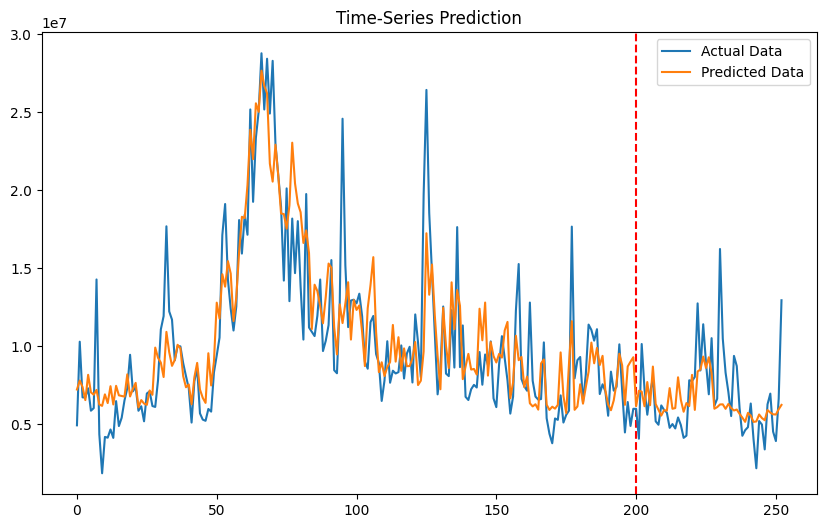

In [22]:
df_x_ss = ss.transform(data.iloc[:, :-1])
df_y_ms = ms.transform(data.iloc[:, -1:])

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))
train_predict = model(df_x_ss)
predicted = train_predict.data.numpy()
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10, 6))
plt.axvline(x=200, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()